# **GSoC17 Notes for CMUsphinx**

**Goal: Achieve best in category accuracy in TED talks through DNNs**

**Objectives**: 
>**Train MLP on wsj corpus to get baseline results<br>
Train CNN-LSTM on wsj<br>
Train existing CNN-LSTM on TEDLIUM corpus**

# Training the MLP

Starting off, I'll train a MLP on the walls street journal __wsj__ corpus. This will give me a baseline score.
We choose wsj corpus instead of open corpora because we know the accuracy (3%) we have to achieve .

**22nd May:** Literature review. output classes of MLP tied states or phone states.According to this paper by J. hinton https://www.clsp.jhu.edu/~samuel/pdfs/scarf_mlp.pdf, Tied states were used.

**23rd May:** Writing code to generate log spectra from audio files

Libraries used:<br>**pysoundfile**<br>**python_speech_features**

I used Pysoundfile to read FLAC format files and return np array
python_speech_features provides a logfbank method that takes in a linear array and returns filter bank energies

In [2]:
import numpy as np
from python_speech_features import logfbank
import soundfile as sf
import os

I only used this once to see how many gigabytes of features I can extract from the complete set of wsj audio files.I wrote a faster script (**run.py** in same repo) that saves all features as a numpy array.
feature size (in gigabytes) varies with the window size.<br> 
**winsize Feats(GB)  <br>
0.015-----34GB<br>
0.010-----~53GB**<br>
smaller window size cuts more time slices from a audio. so we get more feature per audio.

When **"nfilt"** param=40, logfbank returns a 40 dim array for every audio clip.

In [ ]:
#for making log feats 
#path to corpus
corpus= '/media/t-rex/F/wsj/wsj0';
#this file contains paths to all flac files
f = open('flac_paths.txt','w')
    
for dir_name,subdir_name,files in os.walk(corpus):
    
    for file in files:
        if file.endswith('.flac'):
            path_2_file = dir_name+'/'+file;
            #print (path_2_file)
            f.write(path_2_file+'\n')
            (s,r) =sf.read(path_2_file)
            logfeats = logfbank(s,r, winlen=0.025, winstep=0.01, nfilt=40, nfft=1024, lowfreq=250, highfreq=None, preemph=0.97);
            np.savetxt('/media/t-rex/F/wsj/wsj_feats/'+file+'.mls',logfeats)
            


<br>

**25th May**: Assigning labels to features

This script reads a feature file (**.mls**) and assigns it a TIED state label from (0,2999).
the features are concatenated and compressed and saved in "**data.npz**".

In [24]:
#data prep
from random import randint

all_feats=[]
all_labels=[]
#path to corpus
root = '/media/t-rex/F/wsj/';
feats_file = root+'wsj_feats';


for dir_name,subdir_name,files in os.walk(feats_file):
    for file in files:
        if file.endswith('.mls'):
            path_2_file = dir_name+'/'+file;
            
            #print (path_2_file)
            feat = np.loadtxt('/media/t-rex/F/wsj/wsj_feats/'+file)
            n_frames  = feat.shape[0]

            #assigning random labels 
            labels = [randint(0,2999) for i in range(n_frames)]
            all_labels+=list(labels)
            all_feats += list(feat)
            
print(len(all_feats),len(all_labels))
#test/train split
for_training = int(len(all_feats)*0.8)
Xtrain = all_feats[:for_training]
ytrain = all_labels[:for_training]
Xtest = all_feats[for_training:]
ytest = all_labels[for_training:]

#save as compressed array
np.savez(root+'data',Xtrain=Xtrain,ytrain=ytrain,Xtest=Xtest,ytest=ytest)



(16786, 16786)


In [ ]:
#or save as pickle

# import pickle
# pickle.dump(Xtrain,open(root+"Xtrain.p","w"))
# pickle.dump(ytrain,open(root+"ytrain.p","w"))
# pickle.dump(Xtest,open(root+"Xtest.p","w"))
# pickle.dump(ytest,open(root+"ytest.p","w"))


**May 26th**: Writing MLP code

Libraries used:<br>**Tensorflow**<br>**keras**

In [37]:
#using this function for printing graphs
def printgraph(model,name1,name2,display=1,cmdline=0):
    import matplotlib.pyplot as plt
    
    if cmdline==1:
        #if running on commandline
        import matplotlib
        matplotlib.use('Agg')
        
    plt.plot(model.history['acc'])
    plt.plot(model.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc='lower right')
    #show graphs
    if display==1:
        plt.show()
    plt.savefig(name1)
    
    plt.plot(model.history['loss'])
    plt.title('Model Loss')
    plt.plot(model.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc='lower right')
    if display==1:
        plt.show()
    plt.savefig(name2)


In [ ]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import os
import numpy as np
from keras.utils import to_categorical

Using TensorFlow backend.


This cell loads stored features and labels from compressed numpy arrays

In [ ]:
#loading data from compressed arrays
xtrain = np.load('/home/hammadabdullah/MLP-HMM_cmusphinx/Xtrain.npz')
ytrain = np.load('/home/hammadabdullah/MLP-HMM_cmusphinx/ytrain.npz')
xtest = np.load('/home/hammadabdullah/MLP-HMM_cmusphinx/Xtest.npz')
ytest = np.load('/home/hammadabdullah/MLP-HMM_cmusphinx/ytest.npz')

#parsing test/train 
x_train = xtrain['arr_0']
y_train = ytrain['arr_0']
x_test = xtest['arr_0']
y_test = ytest['arr_0']

#using only 1 million features. to_categorical() runs out of memory for bigger arrays
x_train = x_train[:1000000]
y_train = y_train[:1000000]
x_test = x_test[:1000000]
y_test = y_test[:1000000]

In [5]:
#The total number of train and test features we will train on
print x_train.shape
print y_train.shape

(1000000, 40)
(1000000,)


In [6]:
y_train = to_categorical(y_train, num_classes = 3000)

**This MLP model uses SGD optimization, relu activations and runs for 10 epochs**


In [7]:
model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=40))
model.add(Dense(1000, activation='relu'))
model.add(Dense(3000, activation='softmax'))
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



hist=model.fit(x_train,y_train,verbose = 2,validation_split=0.33,epochs=10,batch_size=20000)


Train on 669999 samples, validate on 330001 samples
Epoch 1/10
36s - loss: 8.2269 - acc: 3.4328e-04 - val_loss: 8.0891 - val_acc: 2.8788e-04
Epoch 2/10
31s - loss: 8.0508 - acc: 3.5522e-04 - val_loss: 8.0381 - val_acc: 2.9697e-04
Epoch 3/10
31s - loss: 8.0254 - acc: 3.4776e-04 - val_loss: 8.0234 - val_acc: 3.2424e-04
Epoch 4/10
31s - loss: 8.0168 - acc: 3.5224e-04 - val_loss: 8.0172 - val_acc: 3.1818e-04
Epoch 5/10
31s - loss: 8.0129 - acc: 3.5373e-04 - val_loss: 8.0140 - val_acc: 3.7879e-04
Epoch 6/10
31s - loss: 8.0108 - acc: 3.1045e-04 - val_loss: 8.0121 - val_acc: 3.7576e-04
Epoch 7/10
30s - loss: 8.0095 - acc: 3.2687e-04 - val_loss: 8.0109 - val_acc: 3.3939e-04
Epoch 8/10
31s - loss: 8.0088 - acc: 3.6418e-04 - val_loss: 8.0101 - val_acc: 3.4848e-04
Epoch 9/10
31s - loss: 8.0083 - acc: 3.5075e-04 - val_loss: 8.0097 - val_acc: 3.8485e-04
Epoch 10/10
30s - loss: 8.0079 - acc: 3.4328e-04 - val_loss: 8.0093 - val_acc: 3.5454e-04


In [5]:
#this stores and loads our model along with the weights.
model.save('mlp_sgd.h5')
from keras.models import load_model
model = load_model('mlp_sgd.h5')

In [8]:
y_test = to_categorical(y_test, num_classes = 3000)
score = model.evaluate(x_test, y_test, batch_size=20000)
print score

1000000/1000000 [==============================] - 33s     

10 epochs
[8.0087737846374516, 0.0003119999852788169] test
30s - loss: 8.0079 - acc: 3.4328e-04 - val_loss: 8.0093 - val_acc: 3.5454e-04 train



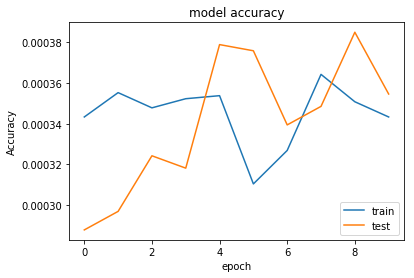

In [12]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.show()
plt.savefig('mlp_1mill_sgd_acc.png')


**Train accuracy:3.4328e-04 <br>Test accuracy:0.0003119999**

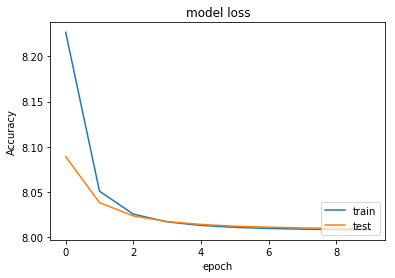

In [13]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.plot(hist.history['val_loss'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.show()
plt.savefig('mlp_1mill_sgd_loss.png')


**Train loss:8.0079 <br>Test Loss:8.0087**

In [11]:
from keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png')

**This MLP model used RMSprop and relu**

In [7]:
model_2 = Sequential()
model_2.add(Dense(1000, activation='relu', input_dim=40))
model_2.add(Dense(1000, activation='relu'))
model_2.add(Dense(3000, activation='softmax'))
model_2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



hist2=model_2.fit(x_train,y_train,verbose = 2,validation_split=0.33,epochs=10,batch_size=20000)

Train on 669999 samples, validate on 330001 samples
Epoch 1/10
38s - loss: 8.0475 - acc: 3.0448e-04 - val_loss: 8.0068 - val_acc: 2.9697e-04
Epoch 2/10
32s - loss: 8.0071 - acc: 3.2836e-04 - val_loss: 8.0086 - val_acc: 3.8788e-04
Epoch 3/10
31s - loss: 8.0070 - acc: 3.7911e-04 - val_loss: 8.0130 - val_acc: 3.6060e-04
Epoch 4/10
31s - loss: 8.0059 - acc: 3.4179e-04 - val_loss: 8.0085 - val_acc: 3.4242e-04
Epoch 5/10
31s - loss: 8.0044 - acc: 4.0896e-04 - val_loss: 8.0100 - val_acc: 3.0606e-04
Epoch 6/10
31s - loss: 8.0033 - acc: 4.6119e-04 - val_loss: 8.0157 - val_acc: 3.2121e-04
Epoch 7/10
31s - loss: 8.0019 - acc: 4.1940e-04 - val_loss: 8.0117 - val_acc: 3.4848e-04
Epoch 8/10
31s - loss: 8.0001 - acc: 4.1791e-04 - val_loss: 8.0172 - val_acc: 3.3939e-04
Epoch 9/10
31s - loss: 7.9986 - acc: 4.7164e-04 - val_loss: 8.0181 - val_acc: 3.2424e-04
Epoch 10/10
31s - loss: 7.9960 - acc: 4.8358e-04 - val_loss: 8.0258 - val_acc: 3.1212e-04


In [8]:
y_test = to_categorical(y_test, num_classes = 3000)


In [9]:
score = model_2.evaluate(x_test, y_test, batch_size=20000)
print score

1000000/1000000 [==============================] - 32s     

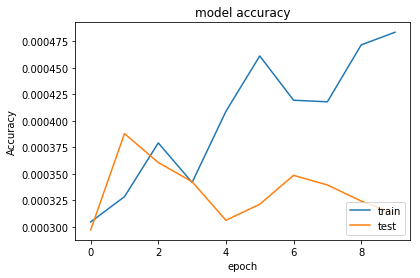

In [10]:
import matplotlib.pyplot as plt

plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.show()
plt.savefig('mlp_1mill_rmsprop_acc.png')


**Train accuracy:4.8358e-04 <br>Test accuracy:0.000337999**

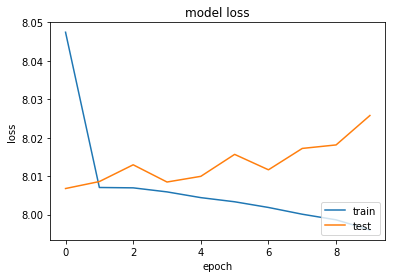

In [19]:
plt.plot(hist2.history['loss'])
plt.title('model loss')
plt.plot(hist2.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.show()
plt.savefig('mlp_1mill_rmsprop_loss.png')


**Train loss: 7.9960<br>Test Loss:8.014094676**

**This MLP model uses adagrad optimizer and relu activations**

In [12]:
model_3 = Sequential()
model_3.add(Dense(1000, activation='relu', input_dim=40))
model_3.add(Dense(1000, activation='relu'))
model_3.add(Dense(3000, activation='softmax'))
model_3.compile(optimizer='adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



hist3=model_3.fit(x_train,y_train,verbose = 2,validation_split=0.33,epochs=10,batch_size=20000)

Train on 669999 samples, validate on 330001 samples
Epoch 1/10
33s - loss: 8.5480 - acc: 2.9552e-04 - val_loss: 8.0069 - val_acc: 2.9091e-04
Epoch 2/10
33s - loss: 8.0051 - acc: 3.9403e-04 - val_loss: 8.0085 - val_acc: 2.9394e-04
Epoch 3/10
33s - loss: 8.0028 - acc: 4.5821e-04 - val_loss: 8.0105 - val_acc: 3.8788e-04
Epoch 4/10
34s - loss: 7.9999 - acc: 4.5821e-04 - val_loss: 8.0152 - val_acc: 3.8182e-04
Epoch 5/10
32s - loss: 7.9967 - acc: 4.7761e-04 - val_loss: 8.0200 - val_acc: 3.4545e-04
Epoch 6/10
32s - loss: 7.9931 - acc: 5.1343e-04 - val_loss: 8.0232 - val_acc: 3.8182e-04
Epoch 7/10
33s - loss: 7.9888 - acc: 4.9403e-04 - val_loss: 8.0267 - val_acc: 4.0000e-04
Epoch 8/10
33s - loss: 7.9847 - acc: 5.7761e-04 - val_loss: 8.0335 - val_acc: 3.7879e-04
Epoch 9/10
33s - loss: 7.9803 - acc: 5.8657e-04 - val_loss: 8.0378 - val_acc: 3.9697e-04
Epoch 10/10
33s - loss: 7.9758 - acc: 6.4925e-04 - val_loss: 8.0403 - val_acc: 4.0606e-04


In [13]:
score = model_3.evaluate(x_test, y_test, batch_size=20000)
print score

1000000/1000000 [==============================] - 28s     

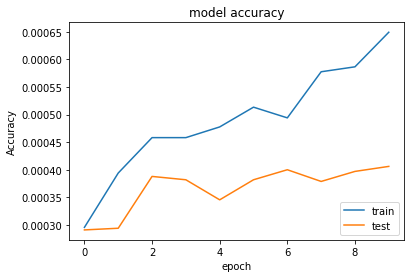

In [16]:
import matplotlib.pyplot as plt

plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.show()
plt.savefig('mlp_1mill_adagrad_acc.png')


**Train accuracy:6.4925e-04 <br>Test accuracy:0.0003479999**

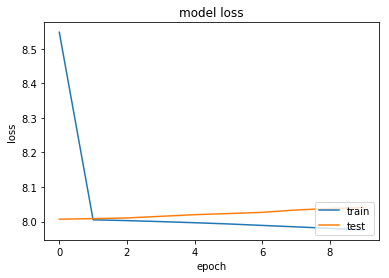

In [18]:
import matplotlib.pyplot as plt

plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.show()
plt.savefig('mlp_1mill_adagrad_acc.png')


**Train loss:7.9758<br>Test Loss:8.02504976**

**May 27th**: Setting up kaldi to find tied state alignments

I install kaldi and all its dependencies.The kaldi distribution comes with a wsj recipe. But I found out our corpus 
is not a LDC distribution, so the recipe won't work. 

Onto Sphinx3_align.

**May 30th**:Refactoring

**June 1st**: Setting up Sphinx3 and 4

Sphinx3_align only reads wav files so I have to convert all flac files to wav.<br>
I used this bash command <br>

**while read in; do sox "`$`in" "`$`in.wav" ; done < flac_paths.txt**<br>
<br>
where flac_paths is file with paths to all flac files.This file was generated using modifying the run.py script

**June 3rd: ** Converting audio files to mfc features.
<br><br>
The command to do that is:<br>
>**sphinx_fe -argfile /media/t-rex/F/sphinx/wsj_all_cd30.mllt_cd_cont_4000/feat.params -c new_paths.ctl  -do feat/ -mswav yes -eo mfc**

<br>
-argfile is wsj model path<br>
-c is for converting multiple audios with a single control file. path to control file follows.<br>
-do is output directory which will contain .mfc features <br>
-mswav is true when input files are wav<br>
-eo is extension of output files<br>

**Computing feats**<br>
<br>
The command to do that is:<br>
>**sphinx3_align -hmm /media/t-rex/F/sphinx/wsj_all_cd30.mllt_cd_cont_4000 -dict cmudict.0.6d.wsj0 -ctl new_paths.ctl -cepdir feat/ -cepext .mfc -insent wsj0.trans -outsent wsj0.out -phlabdir phlabdir -lda wsj_all_cd30.mllt_cd_cont_4000/feature_transform**

<br>
-hmm is model file<br>
-dict is dictionary<br>
-ctl is control file<br>
-cepdir is features folder


**Exam break till 16th**

**June 18th:**

# **Getting Started with CNN-LSTM**


Starting off, I will implement the LSTM without the CTC for preliminary results

Reading up on LSTMs and CTC from these excellent resources:<br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/<br>
http://karpathy.github.io/2015/05/21/rnn-effectiveness/<br>
https://www.cs.toronto.edu/~graves/asru_2013.pdf<br>
https://gab41.lab41.org/speech-recognition-you-down-with-ctc-8d3b558943f0<br>



![alt text](plots/img1.png "Bidirectional LSTM")

>One shortcoming of conventional RNNs is that they are 
only able to make use of previous context. In speech recognition,
where whole utterances are transcribed at once, there
is no reason not to exploit future context as well. Bidirectional
RNNs (BRNNs) do this by processing the data in
both directions with two separate hidden layers, which are
then fed forwards to the same output layer

An Interesting takeaway from the paper is that LSTM-CTC don't need alignments which can be error prone sometimes

>The networks consisted of five bidirectional
hidden levels, each containing two LSTM layers of 250
cells, along with a size 62 softmax output layer (one unit
for each phoneme, plus an extra blank unit)

some specifics:<br>
>+DBLSTM used with CTC has 5 bidirectional layers with 250 units.
+123 dimensional features were used (40 dim log spectra+delta+acc).<br>
+No context frames were used (Added to frame). The RNN models the context internally.<br>
+Whole utterences were used as input, not random sequence of frames from dataset.<br>
+Gaussian noise regularization proved more effectie than dropout and L1, L2.<br>
+Trained on 14 hour train_si_84 training set.<br>
+Tested on test_dev93 set.<br>
+Increasing FER decreases WER.<br>
+SGD used with 10^-4 learning rate and 0.9 momentum.random weight init from [-1,1].<br>
+CTC has 62+1 softmax output for every phoneme plus one blank label.<br>


**June 20th:**

**Using keras LSTM API**

In [59]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,LSTM
from keras.optimizers import SGD
import numpy as np
from keras.utils import to_categorical

In [60]:
#loading data from compressed arrays
xtrain = np.load('/media/t-rex/F/local/xtrain.npy')
#xdev = np.load('wsj0_phonelabels_dev.npy')
xtest = np.load('/media/t-rex/F/local/xtest.npy')
ytrain = np.load('/media/t-rex/F/local/ytrain.npy')
ytest = np.load('/media/t-rex/F/local/ytest.npy')
#test = np.load('/media/t-rex/F/local/data_FILES/wsj0_phonelabels_test.npy')
#meta = np.load('/media/t-rex/F/local/data_FILES/wsj0_phonelabels_meta.npz')
#ytrain= meta['Y_Train']
#ytest =  meta['Y_Test']

In [3]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))


In [7]:
#one hot
ytrain = to_categorical(ytrain, num_classes = 132)
ytest =to_categorical(ytest,num_classes=132)

using 1 million input frames and 50k test frames for testing 

In [61]:
print xtrain.shape
print ytrain.shape
print xtest.shape
print ytest.shape

(5000, 26)
(5000,)
(500, 26)
(500,)


In [4]:
#xtrain = np.concatenate((xtrain,xtest[:950000]),axis=0)
#ytrain = np.concatenate((ytrain,ytest[:950000]),axis=0)
xtest=xtest[:50000]
ytest=ytest[:50000]


### LSTM (1 layer 100 hidden units)

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(1, 26)))
model.add(Dropout(0.2))
model.add(Dense(132, activation='softmax'))
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
lstm_hist = model.fit(xtrain,ytrain,verbose = 2,validation_split=0.2,epochs=50,batch_size=100)



In [23]:
score = model.evaluate(xtest, ytest, batch_size=1000)
print score

50000/50000 [==============================] - 1s     
[3.0690024709701538, 0.19441999852657318]


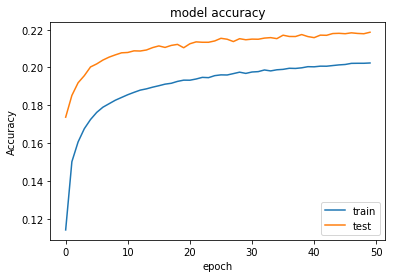

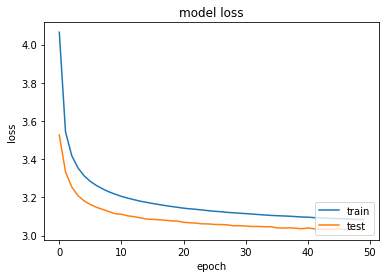

In [24]:
import matplotlib.pyplot as plt

printgraph(lstm_hist,'1layer_acc','1layer_loss',1,0,)

 slighty better results but still needs to improve 

Code to allocate fized amount of GPU memory (set gpu_fraction)<br>
taken from https://groups.google.com/forum/#!topic/keras-users/MFUEY9P1sc8

In [ ]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.8):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())


**June 24th:**

Trained model on entire dataset. **No Change in accuracy.**

**training**
Epoch 50/50<br>
227s - loss: 3.1983 - acc: 0.1815 - val_loss: 2.9937 - val_acc: 0.2029<br>
<br>
**Testing**<br>
4027000/4032885 [============================>.] - ETA: 0s<br>
[loss:3.2138663911548044, acc:0.19911056178495762]<br>

### Stacked LSTM (3 layers with 100 hidden units)

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(1, 26),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, input_shape=(1, 26),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, input_shape=(1, 26)))
model.add(Dropout(0.2))
model.add(Dense(132, activation='softmax'))
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
lstm_hist = model.fit(xtrain,ytrain,verbose = 2,validation_split=0.2,epochs=50,batch_size=100)

In [9]:
score = model.evaluate(xtest, ytest, batch_size=1000)
print score

50000/50000 [==============================] - 4s     
[3.1286358165740968, 0.18588000059127807]


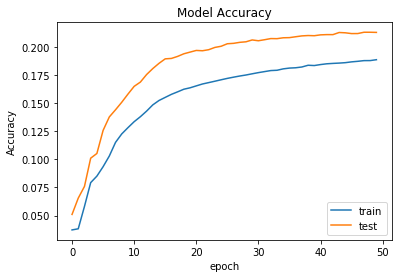

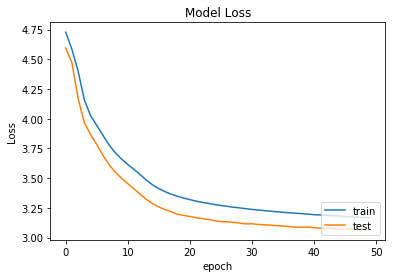

In [12]:
printgraph(lstm_hist,'stacked_acc','stacked_loss',1,0,)

### **stacked LSTM does not generalize well over entire dataset**
(this was a label error)


Epoch 9/50<br>
193s - loss: 4.5673 - acc: 0.0354 - val_loss: 4.5578 - val_acc: 0.0375<br>
Epoch 10/50<br>
194s - loss: 4.5424 - acc: 0.0466 - val_loss: 4.5278 - val_acc: 0.0507<br>

In [6]:
# making sequences
def create_dataset(dataset,targets ,look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0:len(dataset[1])])
        #print targets[i+1:(i+look_back+1)]
        dataY.append(targets[i+1:(i+look_back+1),0:132])
    return np.array(dataX), np.array(dataY)


In [9]:
look_back = 2
trainX, trainY = create_dataset(xtrain,ytrain, look_back)
testX, testY = create_dataset(xtest,ytest, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 26))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 26))

In [23]:
#one hot
trainY = to_categorical(trainY, num_classes = 132)
testY =to_categorical(testY,num_classes=132)

In [22]:
ytrain=0
ytest=0

In [10]:
print trainX.shape
print trainY.shape
print testX.shape
print testY.shape

(999998, 2, 26)
(999998, 2, 132)
(49998, 2, 26)
(49998, 2, 132)


In [13]:
np.save('/media/t-rex/F/big/trainx',trainX)
np.save('/media/t-rex/F/big/trainy',trainY)
np.save('/media/t-rex/F/big/testx',testX)
np.save('/media/t-rex/F/big/testy',testY)

In [ ]:
from keras.utils import plot_model

model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 26),return_sequences= True))
model.add(Dropout(0.3))
model.add(Dense(132,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

lstm_hist=model.fit(trainX, trainY, epochs=5, validation_split=0.2,batch_size=1000, verbose=2)





In [35]:
score = model.evaluate(testX,testY, batch_size=1000)
print score

49998/49998 [==============================] - 6s     
[3.0271602857446207, 0.20701828097144559]


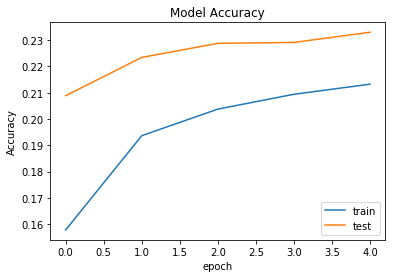

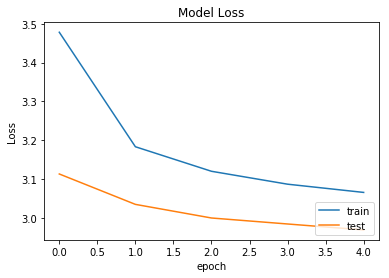

In [38]:
printgraph(lstm_hist,'singlelayer_acc','singlelayer_loss',1,0,)

This model was trained with window size 2. I will train it again with a larger window size and update<br>
Then I will train a stacked LSTM on the same window size

![alt text](plots/acc.png "Accuracy")

With window size 3.Test accuracy is **29%**.<br>
There also seems to be an issue with the labels. accuracy should start at 0


model.save(filepath)
keras.models.load_model(filepath)

**June 29th:**

In [63]:
#function that produces deltas and double deltas
def deltas(array):
    #check dimensions per frame
    dim = array.shape[1]
    num_frames = array.shape[0]
    #print "dim",dim
    #print "num_frames",num_frames
    delta=[]
    delta_rows=[]
    for i in range (num_frames):
        for j in range(dim):
            t1 = j-1
            t2 = j+1
            if t1 < 0:
                t1 = 0
            if t2 > dim-1:
                t2 = dim-1
        
            delta_tmp = array[i,t2]-array[i,t1]
            delta_rows.append(delta_tmp)
        delta.append(delta_rows)
        delta_rows= []
    delta = np.array(delta)
    return delta



In [64]:
#function to fuse delta and Acc into dataset
def fuse(dataset,delta_array,acc_array):
    new_dataset = []
    dim = dataset.shape[1]
    num_frames = dataset.shape[0]
    for i in range(num_frames):
        a = dataset[i]
        b = delta_array[i]
        c = acc_array[i]
        abc = np.concatenate((a,b,c),axis=0)
        new_dataset.append(abc)
    return np.array(new_dataset)
        

In [ ]:
from keras.utils import plot_model
from keras.layers import Bidirectional

model = Sequential()
#5 bidirectional hidden layers
model.add(Bidirectional(LSTM(250,return_sequences= True) input_shape=(look_back, 26)))
model.add(GaussianNoise(0.075))
model.add(Bidirectional(LSTM(250,return_sequences= True) input_shape=(look_back, 26)))
model.add(GaussianNoise(0.075))
model.add(Bidirectional(LSTM(250,return_sequences= True) input_shape=(look_back, 26)))
model.add(GaussianNoise(0.075))
model.add(Bidirectional(LSTM(250,return_sequences= True) input_shape=(look_back, 26)))
model.add(GaussianNoise(0.075))
model.add(Bidirectional(LSTM(250) input_shape=(look_back, 26)))
model.add(GaussianNoise(0.075))
model.add(Dense(132,activation='softmax'))
model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])

lstm_hist=model.fit(trainX, trainY, epochs=25, validation_data={testX,testY},batch_size=1000, verbose=2)





Task for today: replicate this model (which is the exact model used in
alex graves paper minus the shortcut mapping) into tensorflow

In [ ]:
printgraph(lstm_hist,'paper_acc','paper_loss',1,0,)

**June 30th**

In [ ]:
#testing d,dd functions
x=[[i for i in range(26)]]
for j in range(10):
    x.append([i for i in range(26)])
x = np.array(x)
delta = deltas(x)
acc = deltas(d)
x = fuse(x,delta,acc)
#print x

changed all feature array dtype to float32<br>
Added d,dd feats to training dataset<br>
>before (29027263, 26)<br>
after (29027263, 78)

created whole utt as sequences<br>

**July 1st:**

Plotting uttr length distribution to find optimal maximum sequence length

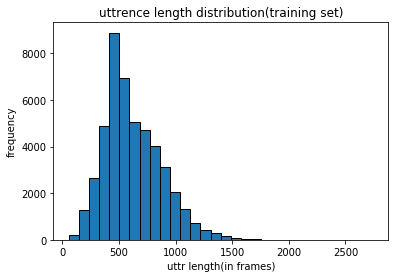

In [11]:
import numpy as np
import matplotlib.pyplot as plt
seq = np.load('/home/hammad/trainframe.npy')
abs_len = [seq[i]-seq[i-1] for i in range(1,len(seq))]
seq =0
plt.hist(abs_len,edgecolor='black',bins=30)
plt.title('uttrence length distribution(training set)')
plt.xlabel('uttr length(in frames)')
plt.ylabel('frequency')
plt.show()

600 frames looks like a good cut off length

**July 3rd:**

In [1]:
#converts entire dataset into sequences of utterance.(computation and memory intensive)
def to_seq(path_to_oldxtrain,path_to_trainframe,cutoff=500,verbose=0):
    vrb=verbose
    #converting dataset into sequences
    #old(27027263,78)
    #new(46757,max_seq_length,78)
    #will save .npy in current dir
    print "Starting up..."
    import numpy as np
    newXTrain=[]
    oldXTrain=np.load(path_to_oldxtrain)#"/home/hammad/xtrain.npy"
    oldXFrame=np.load(path_to_trainframe)#"/home/hammad/trainframe.npy"
    uttr=0
    tmp_seq=[]
    flg1=0
    flg2=0
    max_seq=cutoff
    print "old xtrain shape",oldXTrain.shape
    print "frame end pointer shape",oldXFrame.shape
    for i in range(len(oldXFrame)):#0->46k
        if vrb:
            print "uttr no:",i

        if oldXFrame[i]-uttr <max_seq:#zeropad
                if vrb:
                    print "Flag 1 "
                    
                flg1=1
        if oldXFrame[i]-uttr >max_seq:#truncate
                if vrb:
                    print "Flag 2 "
                
                flg2=1
                
        if vrb:        
            print "uttr_start,uttr_end",uttr,oldXFrame[i]

        tmp_seq.append(oldXTrain[uttr:oldXFrame[i],0:78])
        if vrb:
            print "tmp dim:",np.array(tmp_seq).shape
        
        seq_length = oldXFrame[i]-uttr
        uttr = oldXFrame[i]+1  


        if flg1:#zeropad
            if vrb:
                print "max_seq-seq_length",max_seq,seq_length
            
            pad_length = max_seq - seq_length
            pad_matrix=[[[0 for x in range(78)] for y in range(pad_length)]]
            if vrb:
                print "shape of pad matrix",np.array(pad_matrix).shape
            
            tmp_seq= np.append(tmp_seq,pad_matrix,axis=1)
            flg1=0
            tmp_seq=list(tmp_seq)

        if flg2:#truncate
            if vrb:
                print "bef trunc shape",np.array(tmp_seq).shape
                
            tmp = tmp_seq[0]
            tmp_seq=[tmp[0:500,0:79]]
            flg2=0
        if vrb:
            print "tmp dim after modification:",np.array(tmp_seq).shape

        if i==0:
            newXTrain=tmp_seq
            #tmp_seq.dtype
        else:
            newXTrain= np.append(newXTrain,tmp_seq,axis=0)
            if vrb:
                print newXTrain.shape
            newXTrain.astype(np.float32)
        if vrb:
            print "    NEWXTRAIN:",np.array(newXTrain).shape

        tmp_seq = []
    
    newXTrain.astype(np.float32)
    print "Final shape",newXTrain.shape
    np.save("newXTrain",newXTrain)
    

In [ ]:
to_seq("/home/hammad/xtrain.npy","/home/hammad/trainframe.npy",500,1)

In [ ]:
#this generates a sequence of frames per utterance and will be called during training time
#
global_state=0
def batch_generator(path_to_xtrain,path_to_trainframe,path_to_labels,random=1):
    #Xtrain:dataset trainframe:array of uttr frame positions #labels: targets
        
    Xtrain   = np.load(path_to_xtrain)
    frames   = np.load(path_to_trainframe)
    labels   = np.load(path_to_labels)
    
    if random== 1:
        uttr = global_state
        if global_state>46757:
            global_state+=1
        else:
            return 2# reached end of epoch
    else:
        uttr = random.randint(0,46756)
     
    uttr_strt= frames[uttr-1]+1
    uttr_end = frames[uttr]
    
    uttr_seq = Xtrain[uttr_strt:uttr_end,0:78]
    uttr_lbl = labels[uttr_strt+1:uttr_end+1]#shifting labels by one
    uttr_lbl[end]=132 #labels=1 to 131+132(special)
    
    return np.array(uttr_seq,uttr_lbl)

**5th july**:


I trained **a single layer bidirectional LSTM** on whole utterances (only used 5k uttr out of ~60k) and got **46%** test accuracy.<br>The higher validation (and test) accuracy is perplexing. 

***TEST ACCURACY***<br>
500/500 [==============================] - 2s <br>
[1.5902665615081788, 0.46951194405555724]


![alt text](plots/acc2.png "Accuracy")

### This model was trained on 5k utterances. Since I can't fit all utternces in memory and run operations on them,I will batch feed it manually.

In [2]:
#fetch utternce at runtime
def to_seq(X,labels,uttr,cutoff,framepointer):
    
    uttr_strt = framepointer[uttr-1]+1
    uttr_end = framepointer[uttr]
    #print "utt start ,utt end",uttr_strt,uttr_end
    seq = X[uttr_strt:uttr_end,0:78]
    seq_labels = labels[uttr_strt+1:uttr_end+1]
    seq_labels = to_categorical(seq_labels,num_classes =132)
    
    print "to_seq"
    #print "before modification",np.array(seq).shape
    #print "before modification label",np.array(seq_labels).shape
    seq_length = uttr_end - uttr_strt
    if  seq_length < cutoff:#zero pad
        pad_length = cutoff - seq_length
        pad_matrix=[[[0 for x in range(78)] for y in range(pad_length)]]
        #print "pad_shape",np.array(pad_matrix).shape
        pad_matrix_label = [[[0 for x in range(132)] for y in range(pad_length)]]
        seq= np.append([seq],pad_matrix,axis=1)
        seq_labels=np.append([seq_labels],pad_matrix_label,axis=1)
        seq=list(seq)
        seq_labels=list(seq_labels)
        #print "zero padding"
        
    if seq_length > cutoff:#truncate:
        seq = [seq[:500,0:78]]
        seq_labels= [seq_labels[:500]]
        #print "truncate"
    
    #print "after modification",np.array(seq).shape
    #print "after modification",np.array(seq_labels).shape
    return np.array(seq).astype(np.float32),np.array(seq_labels).astype(np.float32)

In [3]:
import numpy as np
X = np.load("/home/hammad/xtrain.npy")
print X.shape
Y = np.load("/home/hammad/Ytrain.npy")
print Y.shape

(29027263, 78)
(29027263,)


In [6]:
to_seq(X,Y,7,500,frame)

to_seq


(array([[[-3.68176174, -3.89426517, -4.08652163, ..., -0.55871165,
           0.11162418,  0.1178056 ],
         [-2.00956178, -3.29156518, -3.66302156, ...,  0.24008822,
           0.3579241 ,  0.00590563],
         [-2.5816617 , -3.88526511, -3.29522157, ..., -1.03801167,
           0.30732429,  0.51010561],
         ..., 
         [ 0.54983819,  2.99283481,  2.66087842, ..., -1.44311178,
          -0.51707584,  0.43950558],
         [ 0.34863818,  2.90783501,  2.49787855, ..., -0.38031173,
           0.64132416,  0.58930564],
         [-0.25856182,  2.94383502,  2.43887854, ..., -0.40331185,
           0.09232426,  0.42940569]]], dtype=float32),
 array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32))

In [5]:
from keras.utils import to_categorical
frame = np.load("/home/hammad/trainframe.npy")

Using TensorFlow backend.


In [9]:
def batch_generator(X, labels,framepointer,cutoff, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 500,78)).astype(np.float32)
    batch_labels = np.zeros((batch_size,500,132)).astype(np.float32)
    while True:
        for i in range(batch_size):
            # choose random index in features
            uttr= np.random.choice(len(framepointer),1)
            #print "uttr",uttr[0]
#             x,y = to_seq(X,Y,uttr[0],cutoff,framepointer)
#             print x.shape, y.shape
            #print "to seq",uttr,cutoff
            batch_features[i],batch_labels[i] = to_seq(X,Y,uttr[0],cutoff,framepointer)
        print batch_features.shape,batch_labels.shape
        return
    #yield batch_features.astype(np.float32), batch_labels.astype(np.float32)

In [ ]:
batch_generator(X,Y,frame,500,100)

**6th july**

Almost done batch feeding it

~39% accuracy on entire dataset.Thats all for training.Writing end to end LSTM in tensorflow

**8th july**

Almost done with tensorflow model

**10th july**

stagnation.Doing literature review

modifying existing functions to support dynamic length utterances

In [2]:
import numpy as np
X = np.load("/home/hammad/xtrain.npy")
Y = np.load("/home/hammad/Ytrain.npy")
frame = np.load("/home/hammad/trainframe.npy")

In [3]:
print "Data loaded"
print "X",X.shape
print "Y",Y.shape
print "frame",frame.shape


Data loaded
X (29027263, 78)
Y (29027263,)
frame (46757,)


In [59]:
def get_uttr_len(uttr,framepointer):
    uttr_strt = framepointer[uttr-1]+1
    uttr_end = framepointer[uttr]
    return uttr_end - uttr_strt

def batch_generator(X, labels,framepointer,cutoff, batch_size):
    
    uttrences = [np.random.choice(len(framepointer),1,replace=False) for x in range(batch_size)]
    uttr_lengths = [get_uttr_len(uttr,framepointer) for uttr in uttrences]
    max_uttr_len = max(uttr_lengths)[0]
    
    #print "max uttr len",max_uttr_len
    uttr_list = []
    uttr_list_labls=[]
    #builds a batch of size N=len(uttrences) 
    for uttr in uttrences:
        uttr_strt = framepointer[uttr-1]+1
        uttr_end = framepointer[uttr]
        uttr_strt=uttr_strt[0]
        uttr_end=uttr_end[0]
        #print uttr_strt,uttr_end       
        seq_labels = labels[uttr_strt+1:uttr_end+1]
        seq_labels = [int(x+1) for x in seq_labels] #adding 1 to all labels so I can use 0 as mask
        #print "max sequence",max(seq_labels)
        
        seq_labels[len(seq_labels)-1]=133 #last symbol is special symbol
        #print seq_labels
        uttr_list.append(X[uttr_strt:uttr_end,0:78])
        uttr_list_labls.append(seq_labels)
    
    uttr_list= sequence.pad_sequences(uttr_list, maxlen=max_uttr_len, dtype='float32',padding='post',truncating='post' )
    uttr_list_labls = sequence.pad_sequences(uttr_list_labls, maxlen=max_uttr_len, dtype='int16',padding='post',truncating='post')
    #print "uttr_list shape",np.array(uttr_list).shape
    #print "uttr_list_labls shape",np.array(uttr_list_labls).shape
    
    #print uttr_list[0],np.array(uttr_list[0]).shape
    #print uttr_list_labls[0],np.array(uttr_list_labls[0]).shape
    new_labels = []
    for label in uttr_list_labls:
            label= to_categorical(label,num_classes=134)
            new_labels.append(label)
    
    return np.array(uttr_list).astype(np.float32), np.array(new_labels).astype(np.int32)

In [46]:
from keras.preprocessing import sequence
from keras.utils import to_categorical

batch_generator(X,Y,frame,500,30)

![alt text](plots/accc.png "Accuracy")

**July 15**

Understanding how CTC works. Finding alt solutions

![alt text](plots/hubub.png "Accuracy")

![alt text](plots/hububub.png "Accuracy")

LSTM training acc on 26k utterances. 2 layer bidirectional with gaussian noise (testing results very soon)

![alt text](plots/acc_latest.png "Accuracy")

**17th july**

XTRAIN(15443438, 75) total uttr (24590,) <br>
XTEST(364880, 75) total uttr (520,) <br>
XDEV(669322, 75) total uttr (1103,) <br>


**18th july**

interesting read:https://www.cs.cmu.edu/~rsingh/homepage/papers/sphinx4_eurospeech2003.pdf

![alt text](plots/acclat.png "Accuracy")

Test acc is still ~40%

**23 july**

Connecting LSTM to pocketsphinx

**25 july**

The loss function

rescaling forward and backward variables to avoid underflows

![alt text](plots/loss1.png "Accuracy")

![alt text](plots/loss2.png "Accuracy")

![alt text](plots/loss3.png "Accuracy")

The derivatives

![alt text](plots/derivatives.png "Accuracy")

**27th July**

Almost done integrating NN with sphinx. making code adjustments to mask 0 paddings in predictions

**29th**

Demystifying openFST by writing an example in pyfst

the correct package with the c++11 patch
http://www.openfst.org/twiki/pub/FST/FstDownload/openfst-1.3.4.tar.gz

sentence : "GOOD"


In [1]:
import sys  
import fst
import random
reload(sys)  
sys.setdefaultencoding('utf8')




In [2]:
import random
def ran_lab_prob():
    r = [random.random() for i in range(138)]
    s = sum(r)
    return [i/s for i in r]


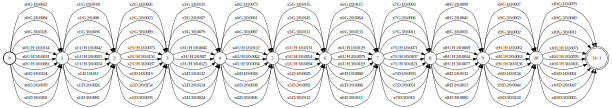

In [3]:
import fst
import random
t = fst.Transducer()
sym=fst.SymbolTable()
#10 timesteps
#138 labels 
#for i in range(138):
x=0
for j in range(11):
    label_prob = ran_lab_prob()
    labels = ['x','x','x','x','x','x','x','x','x']
    symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']
    #labels=[i for i in range(138)]
    for i in range(9):
        prob = "%.4f" % label_prob[i]
        t.add_arc(0+x, 1+x,str(labels[i]+str(j)),symbols[i],prob)
    x+=1
t[11].final = -1
t

GOOD: /G/x3 /UH/x3 /D/x3  for ci

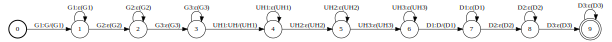

In [4]:
t2=fst.Transducer()
#3x3 states for this example


symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']
labels  = ['G','UH','D']
x=0
count=0
for i in range(1,10):
    if i%3==1:
        t2.add_arc(0+x,1+x,symbols[x],str(labels[count]+"/"+"("+symbols[x]+")"))
    else:
        t2.add_arc(0+x,1+x,symbols[x],str(sym.find(0)+"("+symbols[x]+")"))
    t2.add_arc(1+x,1+x,symbols[x],str(sym.find(0)+"("+symbols[x]+")"))
    print "i",i
    if i%3==0:
        count+=1
    x+=1
    
t2[9].final=True
t2


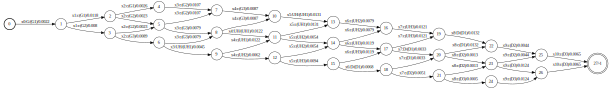

In [5]:
t3 = t>>t2
t3.write("fst.bin")
t3.isyms.write("fst.isysm.bin")
t3.osyms.write("fst.osysm.bin")

t3

sentence = "tis a good day"

In [6]:
import fst
t3 = fst.read("fst.bin")
t3.isyms=fst.read_symbols("fst.isysm.bin")
t3.osyms=fst.read_symbols("fst.osysm.bin")

In [7]:
t= t3.shortest_path()
t

**july 31st**

In [8]:
#make parents dict
parents={}
for state in t3.states:
    for arc in state.arcs:
        if arc.nextstate in parents:
            parents[arc.nextstate].append(state.stateid)
        else:
            parents[arc.nextstate]=[state.stateid]
print parents

#ignore
t=t3
for state in t.states:
    for arc in state.arcs:
        print state.stateid,arc.nextstate,\
        t.isyms.find(arc.ilabel),\
        t.osyms.find(arc.olabel),arc.weight

In [9]:
#forward pass
import math
graph=t3
scores ={0:1}
print "zerroo",scores[0]
def get_key(value):
    for i in range(len(scores)):
        if scores[i]==value:
            return i
def get_max_par(parents):
    if len(parents)!=1:
        if scores[parents[0]] < scores[parents[1]]:
            return parents[1]
        else:
            return parents[0]
    else:
        return parents[0]
    
bestparent={}
bestparent_sym={}
for state in graph.states:
    if state.stateid==0:
        #print "zero",state.stateid
        continue
    else:
        curr_state  = state
        Parents = parents[curr_state.stateid]
        max_par = get_max_par(Parents)
        t = graph[max_par]
        weight=0
        isym=0
        osym=0
        for arc in t.arcs:
            if graph[arc.nextstate].stateid == curr_state.stateid:
                weight=arc.weight
                isym=graph.isyms.find(arc.ilabel)
                osym=graph.osyms.find(arc.olabel)
                print osym
        #print "curr_state",curr_state.stateid
        #print Parents
        #print "max_par",max_par
        #print "weight",weight
        #print scores[max_par]
        scores[curr_state.stateid]=scores[max_par]+math.log(weight)
        bestparent[curr_state.stateid]=max_par
        bestparent_sym[curr_state.stateid]=osym
print scores
print bestparent
print bestparent_sym

In [10]:
state=0
path=[27]
alphas=[]
i=27
while i!=0:
    state=bestparent[i]
    i=state
    path.append(state)
print path
alphas=[scores[p] for p in path]
print alphas

In [11]:
#backward pass
bestpath_symbol={}
bestpath_score={}
bestpath_symbol[27]=bestparent_sym[27].encode("utf-8").replace("\xce\xb5","EPS")
bestpath_score[27]=scores[27]
#print bestpath_symbol
for i in reversed(range(1,27)):
    bestpath_symbol[i]=bestparent_sym[i].encode("utf-8").replace("\xce\xb5","EPS")
    bestpath_score[i]=scores[i]
print bestpath_symbol
print bestpath_score

**August 1st**

Adding the best path code to the NN training script. this will train the NN on labels predicted by the best path code after the 3rd epoch

**August 3rd**

wrote code for best path training.completing NN integration

**August 9th**

Fixing segmentation errors and finishing NN integration

**August 13th**

Fixed segmentaion faults

**August 15th**

pocketsphinx gives no output.scaling suggested. difference in number of frame produced by ps

**August 17th**

scores were scaled. but pocketsphinx gives no text prediction..this might be <br>
because phoneme sequence isn't making sense according to lm. following advice to change beams and lm prob weight
param<br>
<br>
(11_6_1/wsj0/si_dt_20/050/050a0501.wv1.flac -7906)<br>
(11_6_1/wsj0/si_dt_20/050/050a0502.wv1.flac -11488)<br>
(11_6_1/wsj0/si_dt_20/050/050a0503.wv1.flac -10273)

**August 20th**

Reading the pocketsphinx source code and fixing the no text prediction problem

**August 22nd**

Fixed the no text prediction problem. but output is still non sensical. needs scaling

**August 23rd**

Trained a new model, 3 layered DBLSTM with a small change in output sequence generation

**August 24th**

Looks like the new trained model is working, output needed scaling<br>
<br>
.hyp looks like this<br>

**THE MAO PRODUCES A LETTER OF TWO CHIEFLY U. M. BYRNE DECEMBER (11_6_1/wsj0/si_dt_20/050/050a0501.wv1.flac -31532)<br>
NUMEROUS WORKS OF OUR JOB ACE ON THIS STORY OF THIS AKRON OF ISAAC (11_6_1/wsj0/si_dt_20/050/050a0502.wv1.flac -33916)<br>
THEIR SOLUTION REQUIRES DEVELOPMENT OF THE HUMAN CAPACITY FOR SOCIAL INTEREST (11_6_1/wsj0/si_dt_20/050/050a0503.wv1.flac -13529)<br>
HIS MOST SIGNIFICANCE I TO TO PUBLICATIONS WERE STUDIES OF BIRDS IN ANIMALS (11_6_1/wsj0/si_dt_20/050/050a0504.wv1.flac -20610)<br>
IN REA YEARS SHE HAS PRIMARILY APPEARED IN TELEVISION FILMS SUCH AS LOW TO LAURA (11_6_1/wsj0/si_dt_20/050/050a0505.wv1.flac -29449)<br>
THE PROCESS BY WHICH THE LENS FOCUSES ON EXTERNAL OBJECTS IS CALLED ACCOMMODATION (11_6_1/wsj0/si_dt_20/050/050a0506.wv1.flac -13479)<br>
TO NOW GAUGE RAILROADS FROM CHINA ENTER THE CITY FROM THAN THAN EAST AND NORTHWEST (11_6_1/wsj0/si_dt_20/050/050a0507.wv1.flac -31539)**<br>

.log file looks like this<br>
<br>
the FEMALE produces a   LITTER of  two TO  FOUR YOUNG   IN  NOVEMBER AND   december  (11_6_1/wsj0/si_dt_20/050/050a0501.wv1.flac)<br>
the MAO    produces a   LETTER of  two *** ***  CHIEFLY U   M        BYRNE december  (11_6_1/wsj0/si_dt_20/050/050a0501.wv1.flac)<br>
Words: 14 Correct: 6 Errors: 8 Percent correct = 42.86% Error = 57.14% Accuracy = 42.86%<br>
Insertions: 0 Deletions: 2 Substitutions: 6<br>
numerous works of  ART ARE BASED on  THE  story of  THE  SACRIFICE of  isaac (11_6_1/wsj0/si_dt_20/050/050a0502.wv1.flac)
numerous works of  OUR JOB ACE   on  THIS story of  THIS AKRON     of  isaac  (11_6_1/wsj0/si_dt_20/050/050a0502.wv1.flac)
Words: 14 Correct: 8 Errors: 6 Percent correct = 57.14% Error = 42.86% Accuracy = 57.14%<br>
Insertions: 0 Deletions: 0 Substitutions: 6<br>
their solution requires development of  the human capacity for social interest  (11_6_1/wsj0/si_dt_20/050/050a0503.wv1.flac)<br>
their solution requires development of  the human capacity for social interest  (11_6_1/wsj0/si_dt_20/050/050a0503.wv1.flac)<br>
Words: 11 Correct: 11 Errors: 0 Percent correct = 100.00% Error = 0.00% Accuracy = 100.00%<br>
Insertions: 0 Deletions: 0 Substitutions: 0<br>
his most ***          *** SIGNIFICANT SCIENTIFIC publications were studies of  birds AND animals  (11_6_1/wsj0/si_dt_20/050/050a0504.wv1.flac)<br>
his most SIGNIFICANCE I   TO          TO         publications were studies of  birds IN  animals  (11_6_1/wsj0/si_dt_20/050/050a0504.wv1.flac)<br>
Words: 11 Correct: 8 Errors: 5 Percent correct = 72.73% Error = 45.45% Accuracy = 54.55%<br>
Insertions: 2 Deletions: 0 Substitutions: 3<br>
in  RECENT years she has primarily appeared in  television films such as  LITTLE GLORIA  (11_6_1/wsj0/si_dt_20/050/050a0505.wv1.flac)<br>
in  REA    years she has primarily appeared in  television films such as  LOW TO     LAURA   (11_6_1/wsj0/si_dt_20/050/050a0505.wv1.flac)<br>
Words: 14 Correct: 11 Errors: 4 Percent correct = 78.57% Error = 28.57% Accuracy = 71.43%<br>
Insertions: 1 Deletions: 0 Substitutions: 3<br>
the process by  which the lens focuses on  external objects is  called accommodation  (11_6_1/wsj0/si_dt_20/050/050a0506.wv1.flac)<br>
the process by  which the lens focuses on  external objects is  called accommodation  (11_6_1/wsj0/si_dt_20/050/050a0506.wv1.flac)<br>
Words: 13 Correct: 13 Errors: 0 Percent correct = 100.00% Error = 0.00% Accuracy = 100.00%<br>
Insertions: 0 Deletions: 0 Substitutions: 0<br>

**August 25th**

Training the model with new data to increase accuracy and starting with the integration.
